In [1]:
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
from os import path


from ppxf.ppxf import ppxf, robust_sigma

import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from plotbin.plot_velfield import plot_velfield

C = 299792.458  # speed of light in km/s

In [2]:
class read_muse_cube(object):
    def __init__(self, wave_range):
        """
        Read MUSE cube, log rebin it and compute coordinates of each spaxel.
        Median FWHM resolution = 2.62Å. Range: 2.51--2.88 (ESOpPXF Purpose
        instrument manual)
        
        """
        filename = '/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/ppxf_spax.fits'  
        hdu = pyfits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data  

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1) # create array of spectra [npix, nx*ny]
        wave = (head['CRVAL3'] + head['CDELT3']*np.arange(npix))   
        pixsize = abs(head["CDELT1"])*3600    # 0.2"

        # Only use a restricted wavelength range
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        spectra = spectra[w, :]
        
        wave = wave[w]/(1+0.02964)

        # Create coordinates centred on the brightest spectrum
        flux = np.nanmean(spectra, 0)
        jm = np.argmax(flux)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*pixsize
        y = (row - row[jm])*pixsize
        velscale = 46.27319167       #C*np.diff(np.log(wave[-2:])) # Smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)
        
        self.spectra = spectra
        self.x = x
        self.y = y
        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.flux = flux
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = 2.62  # Median FWHM resolution of MUSE

In [3]:
def clip_outliers(galaxy, bestfit, goodpixels):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma
    in relative error until the bad bins don't change any more.
    """
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < 3*err)
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels


In [4]:
def fit_and_clean(templates, galaxy, velscale, start, goodpixels0, lam, lam_temp):
    
    print('##############################################################')
    goodpixels = goodpixels0.copy()
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)

    #plt.figure(figsize=(40, 5))
    #plt.subplot(121)
    #pp.plot()

    goodpixels = clip_outliers(galaxy, pp.bestfit, goodpixels)

    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    goodpixels = np.intersect1d(goodpixels, goodpixels0)
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)
    
    #plt.subplot(122)
    #pp.plot()

    optimal_template = templates @ pp.weights
    
    return pp, optimal_template


In [5]:
lam_range_temp = [4610, 8800]   
s = read_muse_cube(lam_range_temp)


In [6]:
signal = np.median(s.spectra, 0)
noise = np.sqrt(signal)
target_sn = 9


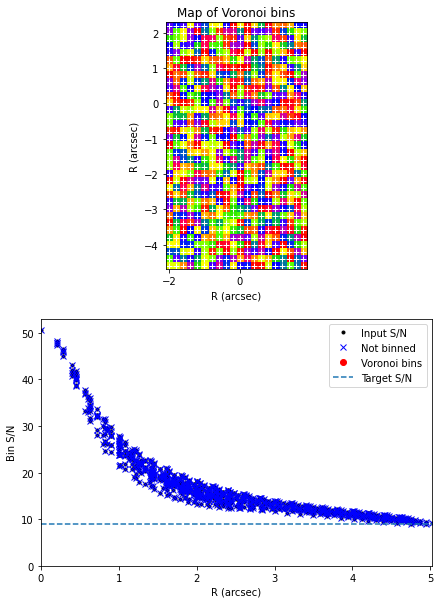

In [7]:
plt.figure(figsize=(7,10))
bin_num, x_gen, y_gen, xbin, ybin, sn, nPixels, scale = voronoi_2d_binning(s.x, s.y, signal, noise, target_sn,pixelsize=0.2, plot=1, quiet=1)

In [8]:
velscale=46.27319167
#C*np.diff(s.ln_lam_gal[:2])   # eq.(8) of Cappellari (2017)
velscale

46.27319167

In [9]:
ppxf_dir = '/home/arshi/anaconda3/lib/python3.9/site-packages/ppxf-8.2.3/ppxf'
pathname = ppxf_dir + '/miles_models/Eun1.30*.fits'
FWHM_gal = None   # set this to None to skip convolutiona
miles = lib.miles(pathname, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = miles.templates, miles.ln_lam_temp
ln_lam_temp


array([ 7.42647743,  7.42663178,  7.42678613, ..., 10.81926133,
       10.81941568, 10.81957003])

In [10]:
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error


In [11]:
#z = 0.002964
z_og=0.02964# redshift estimate from NED
vel0 =0#C*np.log(1 + z)  # Initial estimate of the galaxy velocity in km/s. eq. (8) of Cappellari (2017)
start = [vel0, 200.]  # (km/s), starting guess for [V,sigma]


In [12]:
lam_range_temp = np.exp(ln_lam_temp[[0, -1]])
goodpixels0 = util.determine_goodpixels(s.ln_lam_gal+np.log(1+z_og), lam_range_temp, z_og, width=1000)


In [13]:
nbins = sn.size
velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
optimal_templates = np.empty((stars_templates.shape[0], nbins))
nbins

700

##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -49       183
chi2/DOF: 63.11; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -41       187
chi2/DOF: 41.04; DOF: 3787; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.37
Weighted <[M/H]>: -0.0421
Voronoi bin: 1 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -1       218
chi2/DOF: 5792.; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        -4       238
chi2/DOF: 2073.; DOF: 3742; degree = -1; mdegr

 Best Fit:       Vel     sigma
 comp.  0:        10       215
chi2/DOF: 1320.; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:         4       220
chi2/DOF: 675.9; DOF: 3807; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.62
Weighted <[M/H]>: 0.0524
Voronoi bin: 15 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -3       206
chi2/DOF: 900.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -5       209
chi2/DOF: 564.2; DOF: 3823; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:        -5       224
chi2/DOF: 3303.; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 67; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:       -10       232
chi2/DOF: 1257.; DOF: 3754; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.85
Weighted <[M/H]>: 0.0648
Voronoi bin: 29 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        14       194
chi2/DOF: 1125.; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        11       196
chi2/DOF: 771.0; DOF: 3825; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:       -14       228
chi2/DOF: 443.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -10       233
chi2/DOF: 220.4; DOF: 3786; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 53; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.89
Weighted <[M/H]>: -0.00974
Voronoi bin: 43 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         9       215
chi2/DOF: 304.0; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:         4       221
chi2/DOF: 210.1; DOF: 3820; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status:

 Best Fit:       Vel     sigma
 comp.  0:        -8       190
chi2/DOF: 401.9; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:        -7       197
chi2/DOF: 211.9; DOF: 3806; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.69
Weighted <[M/H]>: -0.0316
Voronoi bin: 57 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -1       231
chi2/DOF: 312.3; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -3       229
chi2/DOF: 244.7; DOF: 3830; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 45; Status: 

 Best Fit:       Vel     sigma
 comp.  0:         2       207
chi2/DOF: 190.7; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:         1       206
chi2/DOF: 147.9; DOF: 3824; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 49; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.64
Weighted <[M/H]>: 0.0184
Voronoi bin: 71 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -1       194
chi2/DOF: 204.2; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        -3       199
chi2/DOF: 149.7; DOF: 3837; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:        -5       206
chi2/DOF: 348.5; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        -7       211
chi2/DOF: 258.1; DOF: 3817; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.61
Weighted <[M/H]>: 0.00883
Voronoi bin: 85 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -7       200
chi2/DOF: 165.3; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 39; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -9       204
chi2/DOF: 118.6; DOF: 3814; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 39; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -19       186
chi2/DOF: 583.0; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -15       207
chi2/DOF: 158.8; DOF: 3785; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 10.0
Weighted <[M/H]>: -0.194
Voronoi bin: 99 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         7       231
chi2/DOF: 145.7; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:         4       230
chi2/DOF: 113.8; DOF: 3818; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 40; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:       -15       177
chi2/DOF: 136.0; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
 Best Fit:       Vel     sigma
 comp.  0:       -19       180
chi2/DOF: 81.95; DOF: 3798; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
Weighted <lg_age> [yr]: 9.61
Weighted <[M/H]>: -0.122
Voronoi bin: 113 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -0       220
chi2/DOF: 118.8; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        -1       218
chi2/DOF: 99.05; DOF: 3833; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 

 Best Fit:       Vel     sigma
 comp.  0:        -9       220
chi2/DOF: 155.8; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        -9       219
chi2/DOF: 120.1; DOF: 3820; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 38; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.74
Weighted <[M/H]>: 0.0130
Voronoi bin: 127 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         1       208
chi2/DOF: 186.3; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        -4       210
chi2/DOF: 153.0; DOF: 3832; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 

 Best Fit:       Vel     sigma
 comp.  0:        -8       212
chi2/DOF: 90.40; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 25; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -10       210
chi2/DOF: 74.86; DOF: 3831; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.66
Weighted <[M/H]>: 0.0221
Voronoi bin: 141 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         1       192
chi2/DOF: 93.96; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 31; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -1       191
chi2/DOF: 75.62; DOF: 3804; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 47; Status: 

 Best Fit:       Vel     sigma
 comp.  0:         9       207
chi2/DOF: 2291.; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 45; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:         2       214
chi2/DOF: 1549.; DOF: 3815; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 58; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.61
Weighted <[M/H]>: 0.0309
Voronoi bin: 155 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         4       182
chi2/DOF: 613.3; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:         7       187
chi2/DOF: 467.6; DOF: 3820; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 58; Status: 

 Best Fit:       Vel     sigma
 comp.  0:        20       233
chi2/DOF: 194.8; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        20       231
chi2/DOF: 147.3; DOF: 3830; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.84
Weighted <[M/H]>: -0.0189
Voronoi bin: 169 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         5       227
chi2/DOF: 189.6; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 61; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150
 Best Fit:       Vel     sigma
 comp.  0:         1       228
chi2/DOF: 161.9; DOF: 3835; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 48; Status:

 Best Fit:       Vel     sigma
 comp.  0:         1       230
chi2/DOF: 168.6; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        -4       228
chi2/DOF: 141.4; DOF: 3838; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.76
Weighted <[M/H]>: 0.0798
Voronoi bin: 183 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -6       180
chi2/DOF: 283.9; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        -9       183
chi2/DOF: 238.7; DOF: 3837; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -12       223
chi2/DOF: 434.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 52; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -11       227
chi2/DOF: 352.4; DOF: 3834; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.76
Weighted <[M/H]>: 0.186
Voronoi bin: 197 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         5       202
chi2/DOF: 744.3; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 60; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -0       213
chi2/DOF: 515.2; DOF: 3814; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 65; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:        12       218
chi2/DOF: 400.4; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:         6       235
chi2/DOF: 278.8; DOF: 3811; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.86
Weighted <[M/H]>: 0.0783
Voronoi bin: 211 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         2       223
chi2/DOF: 407.2; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 60; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:         4       232
chi2/DOF: 261.9; DOF: 3810; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 68; Status: 

 Best Fit:       Vel     sigma
 comp.  0:        -4       202
chi2/DOF: 250.4; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -10       214
chi2/DOF: 178.1; DOF: 3806; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.88
Weighted <[M/H]>: -0.0246
Voronoi bin: 225 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         5       237
chi2/DOF: 153.0; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 40; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -5       236
chi2/DOF: 126.6; DOF: 3831; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 41; Status:

 Best Fit:       Vel     sigma
 comp.  0:        -3       203
chi2/DOF: 173.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -8       207
chi2/DOF: 126.1; DOF: 3826; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.79
Weighted <[M/H]>: -0.00539
Voronoi bin: 239 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -6       203
chi2/DOF: 188.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -10       202
chi2/DOF: 144.6; DOF: 3813; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status

 Best Fit:       Vel     sigma
 comp.  0:         8       209
chi2/DOF: 197.9; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:         2       225
chi2/DOF: 146.4; DOF: 3817; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 68; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.81
Weighted <[M/H]>: -0.000842
Voronoi bin: 253 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -5       195
chi2/DOF: 107.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 66; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -6       202
chi2/DOF: 91.25; DOF: 3836; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Statu

 Best Fit:       Vel     sigma
 comp.  0:       -11       202
chi2/DOF: 81.65; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -10       207
chi2/DOF: 70.16; DOF: 3836; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 39; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.81
Weighted <[M/H]>: 0.0188
Voronoi bin: 267 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -14       172
chi2/DOF: 86.40; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -16       179
chi2/DOF: 71.16; DOF: 3822; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 47; Status: 

 Best Fit:       Vel     sigma
 comp.  0:        23       216
chi2/DOF: 231.0; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 68; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        21       214
chi2/DOF: 199.0; DOF: 3841; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 62; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150
Weighted <lg_age> [yr]: 9.74
Weighted <[M/H]>: 0.0244
Voronoi bin: 281 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         5       204
chi2/DOF: 251.6; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 54; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:         7       215
chi2/DOF: 165.3; DOF: 3793; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -18       210
chi2/DOF: 94.47; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:       -20       209
chi2/DOF: 81.03; DOF: 3835; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.70
Weighted <[M/H]>: -0.0522
Voronoi bin: 295 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -31       195
chi2/DOF: 85.55; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -39       194
chi2/DOF: 72.94; DOF: 3831; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status:

 Best Fit:       Vel     sigma
 comp.  0:        -3       216
chi2/DOF: 97.22; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -12       220
chi2/DOF: 75.83; DOF: 3809; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.51
Weighted <[M/H]>: 0.0526
Voronoi bin: 309 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -17       191
chi2/DOF: 111.9; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
 Best Fit:       Vel     sigma
 comp.  0:       -17       196
chi2/DOF: 93.13; DOF: 3820; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 52; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -39       193
chi2/DOF: 77.91; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -33       199
chi2/DOF: 66.88; DOF: 3832; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.65
Weighted <[M/H]>: -0.0415
Voronoi bin: 323 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         9       205
chi2/DOF: 152.4; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 58; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:         7       210
chi2/DOF: 126.4; DOF: 3826; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 65; Status:

 Best Fit:       Vel     sigma
 comp.  0:        21       187
chi2/DOF: 189.5; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 52; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        17       203
chi2/DOF: 145.9; DOF: 3816; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.28
Weighted <[M/H]>: 0.0616
Voronoi bin: 337 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         7       216
chi2/DOF: 251.7; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 58; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:         5       220
chi2/DOF: 190.6; DOF: 3831; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 61; Status: 

 Best Fit:       Vel     sigma
 comp.  0:        12       213
chi2/DOF: 170.0; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:         8       218
chi2/DOF: 126.3; DOF: 3816; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 47; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.66
Weighted <[M/H]>: 0.0209
Voronoi bin: 351 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        20       202
chi2/DOF: 170.4; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 54; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        19       205
chi2/DOF: 141.9; DOF: 3835; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 60; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -41       204
chi2/DOF: 82.93; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:       -44       203
chi2/DOF: 66.93; DOF: 3826; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
Weighted <lg_age> [yr]: 9.42
Weighted <[M/H]>: 0.111
Voronoi bin: 365 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -26       221
chi2/DOF: 98.75; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 33; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:       -32       218
chi2/DOF: 86.28; DOF: 3833; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:        12       193
chi2/DOF: 112.3; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 58; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:         6       193
chi2/DOF: 92.56; DOF: 3815; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 69; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.49
Weighted <[M/H]>: -0.283
Voronoi bin: 379 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        23       201
chi2/DOF: 154.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 54; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:        21       213
chi2/DOF: 117.7; DOF: 3812; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 

 Best Fit:       Vel     sigma
 comp.  0:        19       191
chi2/DOF: 165.3; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        17       199
chi2/DOF: 118.1; DOF: 3806; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.74
Weighted <[M/H]>: 0.0420
Voronoi bin: 393 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        17       208
chi2/DOF: 137.8; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        16       214
chi2/DOF: 113.3; DOF: 3832; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -47       191
chi2/DOF: 74.26; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -49       196
chi2/DOF: 62.21; DOF: 3824; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.66
Weighted <[M/H]>: -0.0429
Voronoi bin: 407 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        19       212
chi2/DOF: 112.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 55; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        17       208
chi2/DOF: 97.83; DOF: 3839; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 62; Status:

 Best Fit:       Vel     sigma
 comp.  0:        -1       200
chi2/DOF: 144.9; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        -8       200
chi2/DOF: 120.9; DOF: 3838; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.64
Weighted <[M/H]>: 0.106
Voronoi bin: 421 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         0       191
chi2/DOF: 89.99; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:         3       188
chi2/DOF: 78.88; DOF: 3838; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 61; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:       -67       204
chi2/DOF: 96.01; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 45; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:       -68       200
chi2/DOF: 81.44; DOF: 3831; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.54
Weighted <[M/H]>: 0.0160
Voronoi bin: 435 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -59       200
chi2/DOF: 98.71; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -67       197
chi2/DOF: 83.39; DOF: 3829; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 

 Best Fit:       Vel     sigma
 comp.  0:         4       184
chi2/DOF: 65.41; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 54; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:         6       184
chi2/DOF: 54.12; DOF: 3827; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.63
Weighted <[M/H]>: -0.00155
Voronoi bin: 449 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        27       200
chi2/DOF: 139.6; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        27       202
chi2/DOF: 111.4; DOF: 3825; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status

 Best Fit:       Vel     sigma
 comp.  0:       -40       212
chi2/DOF: 75.93; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:       -41       209
chi2/DOF: 65.49; DOF: 3833; degree = -1; mdegree = 4
method = capfit; Jac calls: 10; Func calls: 76; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.42
Weighted <[M/H]>: 0.121
Voronoi bin: 463 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -44       205
chi2/DOF: 90.62; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -51       204
chi2/DOF: 73.06; DOF: 3819; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -59       201
chi2/DOF: 80.26; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:       -58       207
chi2/DOF: 66.07; DOF: 3821; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.81
Weighted <[M/H]>: -0.131
Voronoi bin: 477 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -31       207
chi2/DOF: 57.10; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
 Best Fit:       Vel     sigma
 comp.  0:       -29       206
chi2/DOF: 45.59; DOF: 3817; degree = -1; mdegree = 4
method = capfit; Jac calls: 9; Func calls: 66; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -31       192
chi2/DOF: 78.33; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -41       186
chi2/DOF: 65.81; DOF: 3826; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.30
Weighted <[M/H]>: 0.138
Voronoi bin: 491 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -34       202
chi2/DOF: 63.20; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -33       195
chi2/DOF: 56.28; DOF: 3845; degree = -1; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 23; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:        20       176
chi2/DOF: 134.4; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 60; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:        19       179
chi2/DOF: 104.4; DOF: 3819; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.64
Weighted <[M/H]>: -0.0151
Voronoi bin: 505 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        19       199
chi2/DOF: 98.65; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        21       195
chi2/DOF: 81.56; DOF: 3821; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status:

 Best Fit:       Vel     sigma
 comp.  0:        17       205
chi2/DOF: 97.16; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 54; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:        19       208
chi2/DOF: 83.38; DOF: 3835; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 55; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.59
Weighted <[M/H]>: 0.148
Voronoi bin: 519 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:         3       221
chi2/DOF: 98.32; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 52; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:         6       225
chi2/DOF: 79.57; DOF: 3814; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 53; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:       -32       200
chi2/DOF: 71.24; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -31       197
chi2/DOF: 58.99; DOF: 3819; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
Weighted <lg_age> [yr]: 9.71
Weighted <[M/H]>: -0.0361
Voronoi bin: 533 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -43       199
chi2/DOF: 79.01; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -37       206
chi2/DOF: 62.60; DOF: 3818; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 41; Status:

 Best Fit:       Vel     sigma
 comp.  0:       -51       181
chi2/DOF: 77.72; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 39; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -46       185
chi2/DOF: 60.70; DOF: 3827; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 10/150
Weighted <lg_age> [yr]: 9.73
Weighted <[M/H]>: -0.186
Voronoi bin: 547 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -11       178
chi2/DOF: 64.64; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -10       183
chi2/DOF: 53.36; DOF: 3825; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 47; Status:

 Best Fit:       Vel     sigma
 comp.  0:       -28       165
chi2/DOF: 67.70; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -37       180
chi2/DOF: 53.53; DOF: 3813; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.53
Weighted <[M/H]>: -0.116
Voronoi bin: 561 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -35       213
chi2/DOF: 58.57; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       -30       215
chi2/DOF: 48.48; DOF: 3819; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 33; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -75       185
chi2/DOF: 81.19; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -73       198
chi2/DOF: 54.50; DOF: 3800; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.48
Weighted <[M/H]>: 0.0985
Voronoi bin: 575 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -31       173
chi2/DOF: 58.48; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -31       167
chi2/DOF: 46.87; DOF: 3809; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 

 Best Fit:       Vel     sigma
 comp.  0:        20       211
chi2/DOF: 94.93; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        16       215
chi2/DOF: 81.17; DOF: 3835; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.67
Weighted <[M/H]>: 0.142
Voronoi bin: 589 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -84       169
chi2/DOF: 71.16; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:       -84       171
chi2/DOF: 57.06; DOF: 3822; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2

 Best Fit:       Vel     sigma
 comp.  0:       -79       166
chi2/DOF: 72.99; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
 Best Fit:       Vel     sigma
 comp.  0:       -72       177
chi2/DOF: 50.09; DOF: 3827; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
Weighted <lg_age> [yr]: 9.51
Weighted <[M/H]>: -0.0477
Voronoi bin: 603 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -28       161
chi2/DOF: 59.33; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
 Best Fit:       Vel     sigma
 comp.  0:       -32       173
chi2/DOF: 48.59; DOF: 3815; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status:

 Best Fit:       Vel     sigma
 comp.  0:       -90       175
chi2/DOF: 110.6; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -85       183
chi2/DOF: 54.02; DOF: 3816; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.42
Weighted <[M/H]>: 0.00
Voronoi bin: 617 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -80       195
chi2/DOF: 110.6; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 39; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -63       200
chi2/DOF: 53.59; DOF: 3791; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 61; Status: 2


 Best Fit:       Vel     sigma
 comp.  0:      -112       190
chi2/DOF: 95.63; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:      -102       189
chi2/DOF: 45.35; DOF: 3796; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.81
Weighted <[M/H]>: -0.327
Voronoi bin: 631 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -55       135
chi2/DOF: 56.17; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -52       140
chi2/DOF: 46.80; DOF: 3814; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 

 Best Fit:       Vel     sigma
 comp.  0:       -61       242
chi2/DOF: 92.16; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -47       223
chi2/DOF: 43.07; DOF: 3785; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 47; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.34
Weighted <[M/H]>: -0.301
Voronoi bin: 645 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:      -125       178
chi2/DOF: 154.5; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 33; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150
 Best Fit:       Vel     sigma
 comp.  0:       -97       204
chi2/DOF: 51.44; DOF: 3777; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 32; Status: 

 Best Fit:       Vel     sigma
 comp.  0:      -117       167
chi2/DOF: 109.2; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:      -100       188
chi2/DOF: 48.57; DOF: 3794; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.49
Weighted <[M/H]>: -0.131
Voronoi bin: 659 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -89       220
chi2/DOF: 96.79; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -70       230
chi2/DOF: 48.71; DOF: 3804; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 

 Best Fit:       Vel     sigma
 comp.  0:      -170       172
chi2/DOF: 155.1; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:      -120       196
chi2/DOF: 51.55; DOF: 3771; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
Weighted <lg_age> [yr]: 9.29
Weighted <[M/H]>: -0.0481
Voronoi bin: 673 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       -49       169
chi2/DOF: 53.65; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -47       174
chi2/DOF: 44.89; DOF: 3819; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status:

 Best Fit:       Vel     sigma
 comp.  0:        23       191
chi2/DOF: 95.74; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 39; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:        21       193
chi2/DOF: 77.62; DOF: 3825; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 59; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
Weighted <lg_age> [yr]: 9.71
Weighted <[M/H]>: -0.104
Voronoi bin: 687 / 700
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        10       189
chi2/DOF: 83.92; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        13       188
chi2/DOF: 71.67; DOF: 3833; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 

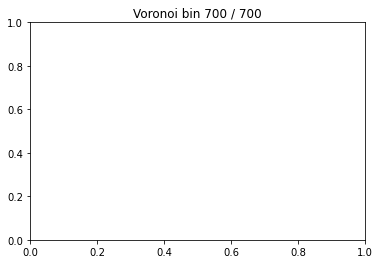

In [14]:
lam_gal = np.exp(s.ln_lam_gal)
for j in range(nbins):
    w = bin_num == j
    galaxy = np.sum(s.spectra[:, w], 1)
    pp, bestfit_template = fit_and_clean(stars_templates, galaxy, velscale, start, goodpixels0, lam_gal, miles.lam_temp)
    velbin[j], sigbin[j] = pp.sol
    optimal_templates[:, j] = bestfit_template
    light_weights = pp.weights.reshape(reg_dim)
    lg_age_bin[j], metalbin[j] = miles.mean_age_metal(light_weights)

    print(f'Voronoi bin: {j + 1} / {nbins}')
    plt.title(f"Voronoi bin {j + 1} / {nbins}")



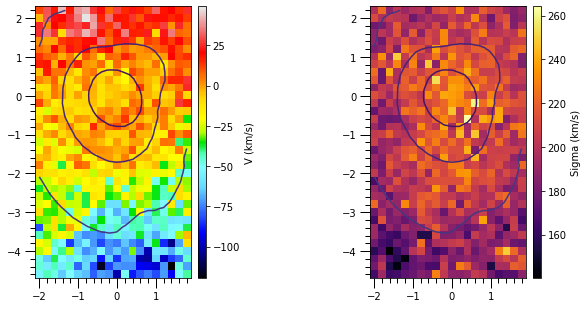

In [15]:
plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
display_bins(s.x, s.y, bin_num, velbin,pixelsize=0.2, colorbar=1, label='V (km/s)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

plt.subplot(122)
display_bins(s.x, s.y, bin_num, sigbin,pixelsize=0.2, colorbar=1, cmap='inferno', label='Sigma (km/s)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

In [16]:
f = open("/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/test.csv", "w")
f.write("{},{},{},{},{},{}\n".format("x", "y","bin","vel","sig","flux"))
for x in zip(s.x, s.y,bin_num,velbin,sigbin,s.flux):
    f.write("{},{},{},{},{},{}\n".format(x[0], x[1], x[2], x[3], x[4], x[5]))
f.close()


In [17]:
import pandas as pd 
file='/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/test.csv'
data=pd.read_csv(file)
data

,x,y,bin,vel,sig,flux
0,-2.0,-4.6,699,-41.067516,187.144589,85.058685
1,-1.8,-4.6,695,-3.940992,237.764533,89.164200
2,-1.6,-4.6,689,-3.933451,236.336128,93.601051
3,-1.4,-4.6,684,-2.514527,222.134928,98.278885
4,-1.2,-4.6,675,-6.197845,239.620007,103.414566
...,...,...,...,...,...,...
695,1.0,2.2,610,-41.978411,192.552784,230.985153
696,1.2,2.2,679,-51.146765,171.226185,218.935165
697,1.4,2.2,686,26.339403,191.415421,203.391434
698,1.6,2.2,694,11.943278,198.022969,186.439209


In [18]:
a1=np.array(data.vel)
velocity=np.reshape(a1, (35,20))

a2=np.array(data.sig)
disp=np.reshape(a2, (35,20))

a3=np.array(data.flux)
flux=np.reshape(a3, (35,20))

a4=np.array(data.bin)
bin=np.reshape(a4, (35,20))


In [19]:
filename = '/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/ppxf_spax.fits'  
hdu = pyfits.open(filename)
head = hdu[0].header
cube = hdu[0].data
hdu.info()

Filename: /home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/ppxf_spax.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      42   (20, 35, 3802)   float32   


In [20]:
new_hdul = pyfits.HDUList()
new_hdul.append(pyfits.ImageHDU(np.zeros((1,1)), name="Primary"))
new_hdul.append(pyfits.ImageHDU(cube, name="MUSE CUBE"))
new_hdul.append(pyfits.ImageHDU(bin, name="BIN/ SPAXELS"))
new_hdul.append(pyfits.ImageHDU(velocity, name="velocity"))
new_hdul.append(pyfits.ImageHDU(disp, name="stellar dispersion"))
new_hdul.append(pyfits.ImageHDU(flux, name="Flux"))

new_hdul.writeto("/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/test.fits", overwrite=True)